# **Artificial Neural Networks and Deep Learning**

---

## ⚙️ **Libraries Import**

In [1]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from datetime import datetime
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2025-11-08 20:37:17.769972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762634237.992753      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762634238.058201      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

PyTorch version: 2.6.0+cu124
Device: cuda


## ⏳ **Data Loading**

In [2]:
# --- 1️⃣ Locale ---
# DATASET_ROOT = Path("./dataset")

# --- 2️⃣ Kaggle ---
DATASET_ROOT = Path("/kaggle/input/pirate-pain")

# --- 3️⃣ Server o cluster privato (es. Westworld/Elysium) ---
# DATASET_ROOT = Path("/multiverse/datasets/private_dataset/pirate_pain")

# --- Verifica ---
print("Dataset root:", DATASET_ROOT)
for path in DATASET_ROOT.glob("*.csv"):
    print(path)

Dataset root: /kaggle/input/pirate-pain
/kaggle/input/pirate-pain/sample_submission.csv
/kaggle/input/pirate-pain/pirate_pain_test.csv
/kaggle/input/pirate-pain/pirate_pain_train_labels.csv
/kaggle/input/pirate-pain/pirate_pain_train.csv


In [3]:
import pandas as pd

# Caricamento dati
X_train = pd.read_csv(DATASET_ROOT / "pirate_pain_train.csv")
X_TRAIN = pd.read_csv(DATASET_ROOT / "pirate_pain_train.csv")

y_train = pd.read_csv(DATASET_ROOT / "pirate_pain_train_labels.csv")
Y_TRAIN = pd.read_csv(DATASET_ROOT / "pirate_pain_train_labels.csv")

X_test  = pd.read_csv(DATASET_ROOT / "pirate_pain_test.csv")

print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_test:  {X_test.shape}")

  X_train: (105760, 40)
  y_train: (661, 2)
  X_test:  (211840, 40)


## 🔎 **Exploration and Data Analysis**

In [4]:
# MERGE BETWEEN TRAIN DATA AND LABELS
# the labels are in a separated file linked through 'sample_index
# here we merge X_train and y_train in a unique Dataframe to explore

train_merge = X_train.merge(y_train, on="sample_index", how="left")

# check whether all the labels have been associated or not
missing_labels = train_merge["label"].isna().sum()
if missing_labels > 0:
    print(f"{missing_labels} rows without a label")

# check
print(train_merge[["sample_index","time","label"]].head())
print("Class Distribution")
print(train_merge["label"].value_counts())

   sample_index  time    label
0             0     0  no_pain
1             0     1  no_pain
2             0     2  no_pain
3             0     3  no_pain
4             0     4  no_pain
Class Distribution
label
no_pain      81760
low_pain     15040
high_pain     8960
Name: count, dtype: int64


## 🔄 **Data Preprocessing**

In [5]:
def dataset_conversion_type(df, label_conversion=False):
    df = df.copy()

    # select all columns starting with joint_
    joint_cols = [col for col in df.columns if col.startswith("joint_")]

    # convert all joint columns in float32
    df[joint_cols] = df[joint_cols].astype(np.float32)

    # select all columns starting with pain_survey_
    pain_survey_cols = [col for col in df.columns if col.startswith("pain_survey_")]
    df[pain_survey_cols] = df[pain_survey_cols].astype(np.int8)

    legs_map = {"two": 0, "one+peg_leg": 1}
    hands_map = {"two": 0, "one+hook_hand": 1}
    eyes_map  = {"two": 0, "one+eye_patch": 1}

    df["n_legs"]  = df["n_legs"].map(legs_map).astype(np.int8)
    df["n_hands"] = df["n_hands"].map(hands_map).astype(np.int8)
    df["n_eyes"]  = df["n_eyes"].map(eyes_map).astype(np.int8)

    return df

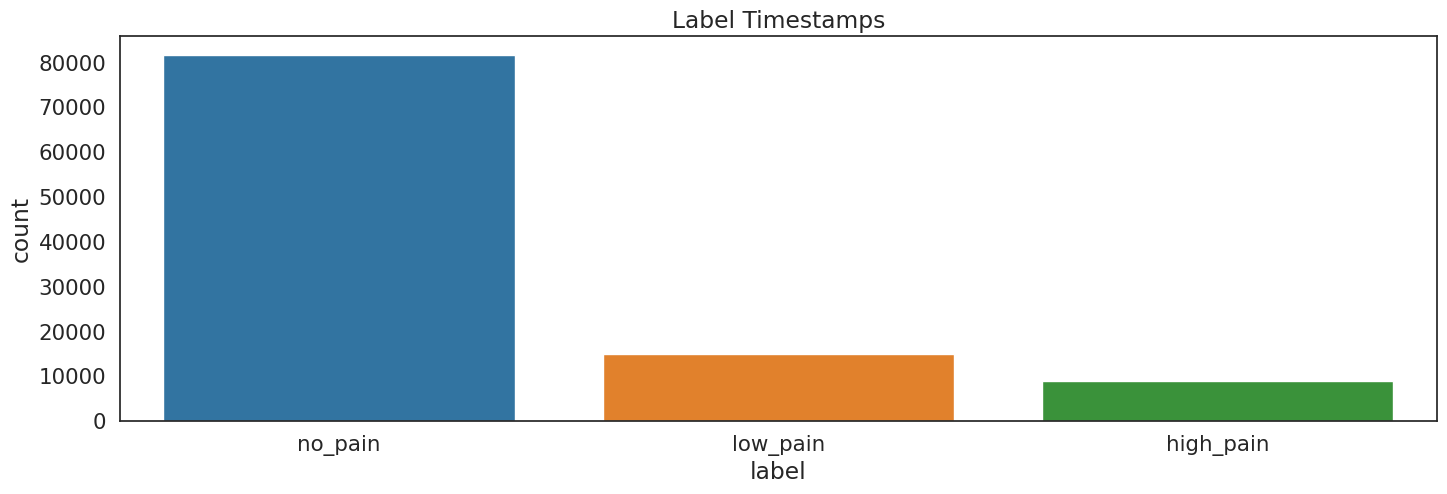

In [6]:
# Visualise the count of timestamps for each kind of pain
plt.figure(figsize=(17, 5))
sns.countplot(
    x='label',
    data=train_merge,
    order=train_merge['label'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Label Timestamps')

# Display the plot
plt.show()

count    661.0
mean     160.0
std        0.0
min      160.0
25%      160.0
50%      160.0
75%      160.0
max      160.0
dtype: float64


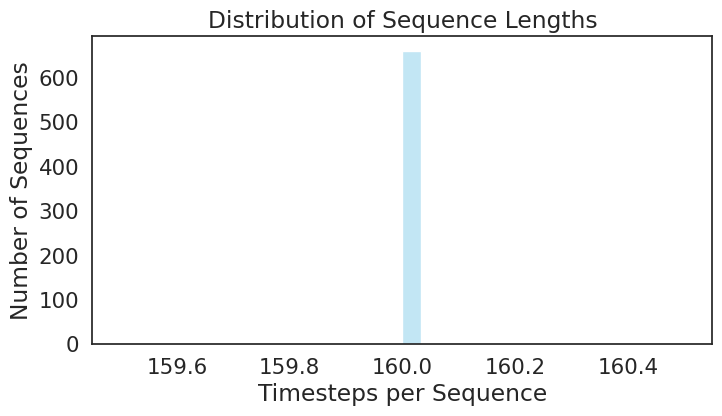

In [7]:
# Count the number of timesteps per sample
seq_lengths = train_merge.groupby("sample_index").size()

# Quick look
print(seq_lengths.describe())

plt.figure(figsize=(8,4))
sns.histplot(seq_lengths, bins=30, kde=True, color="skyblue")
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Timesteps per Sequence")
plt.ylabel("Number of Sequences")
plt.show()


In [8]:
# Define a function to inspect sensor data for a specific pain
def inspect_pain(pain, df, n_rows=500):
    # Filter the DataFrame for the specified pain and limit to 500 rows
    joint_cols = [col for col in df.columns if col.startswith("joint_")]
    data = df[df['label'] == pain][joint_cols][:n_rows]

    # Dynamically adjust figure height based on number of joints
    fig_height = len(joint_cols) * 1  # keep proportions similar to your original
    axis = data.plot(subplots=True, figsize=(17, fig_height), title=pain)

    # Adjust legend position for each subplot
    for ax in axis:
        ax.legend(loc='lower right')


In [9]:
def preprocess_joints(df, 
                      drop_redundant=False, 
                      drop_near_zero=False, 
                      drop_low_var=False,
                      verbose=True):
    """
    Simplify joint_* preprocessing based on EDA results.
    Removes constant, redundant, or near-zero-variance joints.

    Returns a (df_out, feature_cols) tuple.
    """
    joint_cols = sorted([c for c in df.columns if c.startswith("joint_")],
                        key=lambda x: int(x.split("_")[1]))
    drop = set()

    # 1 Drop constant joint_30
    if "joint_30" in joint_cols:
        drop.add("joint_30")

    #  Drop redundant joints (from correlation heatmap)
    if drop_redundant:
        for c in ["joint_01", "joint_02", "joint_05"]:
            if c in joint_cols:
                drop.add(c)

    # Drop near-zero variance joints (joint_13–25)
    if drop_near_zero:
        for i in range(13, 26):
            c = f"joint_{i:02d}"
            if c in joint_cols:
                drop.add(c)

    # (Optional) Drop low-variance but not-zero joints (joint_26–29)
    if drop_low_var:
        for i in range(26, 30):
            c = f"joint_{i:02d}"
            if c in joint_cols:
                drop.add(c)

    # apply
    kept = [c for c in joint_cols if c not in drop]
    df_out = df.drop(columns=list(drop), errors="ignore")

    if verbose:
        print(f"[preprocess_joints] start={len(joint_cols)} | kept={len(kept)} | dropped={len(drop)}")
        if drop:
            print("  • dropped:", sorted(list(drop)))

    return df_out, kept


In [10]:
X_train, _ = preprocess_joints(X_train)
X_test, _ = preprocess_joints(X_test)


[preprocess_joints] start=31 | kept=30 | dropped=1
  • dropped: ['joint_30']
[preprocess_joints] start=31 | kept=30 | dropped=1
  • dropped: ['joint_30']


## 🔄 **Data Preprocessing**

In [11]:
def build_sequences(df: pd.DataFrame, y: pd.DataFrame | None = None):
    """ 
    Build full-length sequences for each sample_index.
    Each sequence corresponds to one complete time series (160 timesteps)
    with one label (pain level) if provided.

    # N: Number of sequences
    # T: Number of timesteps
    # F: number of features (joints + pain surveys + static features)

    Returns:
        dataset: np.ndarray of shape (N,T,F)   
        labels: np.ndarray of shape (N,) if y is provided, else None
    """
    dataset = []
    labels = []

    # Take dynamic and static feature columns
    joint_cols  = [col for col in df.columns if col.startswith('joint_')]
    pain_cols   = [col for col in df.columns if col.startswith('pain_survey_')]
    static_cols = ['n_legs', 'n_hands', 'n_eyes']

    # Sort by sample_index and time to preserve chronological order
    df = df.sort_values(["sample_index", "time"])

    # If labels are provided, build a lookup dictionary: sample_index → label
    label_dict = None
    if y is not None:
        # y can be a numpy array (aligned with unique sample_index order)
        # or a DataFrame with columns ['sample_index', 'label']
        if isinstance(y, np.ndarray):
            # Build mapping using the unique order of sample_index in df
            unique_ids = df["sample_index"].unique()
            label_dict = {sid: lbl for sid, lbl in zip(unique_ids, y)}
        elif isinstance(y, pd.DataFrame):
            label_dict = dict(zip(y["sample_index"], y["label"]))

    # --- Group each full sequence ---
    for sid, group in df.groupby("sample_index"):
        # --- Extract joint values (T, J) ---
        X_joints = group[joint_cols].values.astype(np.float32)

        # --- One-hot encode pain_survey_* columns (each has 3 categories: 0,1,2) ---
        # This turns 4 integer columns into 12 binary columns (4 × 3 one-hot vectors)
        pain_values   = group[pain_cols].values.astype(np.int64)  # shape (T, 4)
        one_hot_pains = [np.eye(3, dtype=np.float32)[pain_values[:, i]] for i in range(pain_values.shape[1])]
        X_pain        = np.concatenate(one_hot_pains, axis=1)     # shape (T, 12)

        # --- Add static features (same for all timesteps but repeated) ---
        # n_legs, n_hands, n_eyes are binary (0 or 1)
        X_static = group[static_cols].values.astype(np.float32)   # shape (T, 3)

        # --- Concatenate all feature groups along the last dimension ---
        seq = np.concatenate([X_joints, X_pain, X_static], axis=1)  # shape (T, F_total)
        dataset.append(seq)

        # --- Retrieve the label for this sequence (if provided) ---
        if label_dict is not None and sid in label_dict:
            labels.append(int(label_dict[sid]))

    # Convert to numpy arrays
    dataset = np.array(dataset, dtype=np.float32)          # shape (N, T, F)
    labels  = np.array(labels, dtype=np.int64) if len(labels) > 0 else None

    print(f"Built {len(dataset)} sequences, each of shape {dataset[0].shape}")
    return dataset, labels


In [12]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches aheads
    )

## 🛠️ **Model Building**

In [13]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [14]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits


## 🧮 **Network and Training Hyperparameters**

## 🧠 **Model Training**

In [15]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [16]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [17]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [18]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [19]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [20]:
def save_experiment_output(
    model_name: str,
    hyperparams: dict,
    X_test_seq: np.ndarray,
    label_mapping: dict,
    sample_indices: list,
    output_dir: str,
    model=None,
    batch_size: int = 256
):
    """
    Run inference on the test set, save predictions and hyperparameters.

    Args:
        model_name (str): Name of the experiment (e.g. 'lstm', 'bilstm', 'ffn').
        hyperparams (dict): Dict containing all hyperparameters and training config.
        X_test_seq (np.ndarray): Test sequences of shape (N, T, F).
        label_mapping (dict): Mapping from label string to class index.
        sample_indices (list): List of sample_index identifiers (as strings).
        output_dir (str): Folder where submission and metadata are saved.
        model (torch.nn.Module): Trained model for inference.
        batch_size (int): Inference batch size.
    """

    os.makedirs(output_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Reverse mapping
    idx2label = {v: k for k, v in label_mapping.items()}

    # --- Inference ---
    model.eval().to(device)
    with torch.inference_mode():
        logits = []
        for i in range(0, len(X_test_seq), batch_size):
            xb = torch.from_numpy(X_test_seq[i:i+batch_size]).to(device)
            logits.append(model(xb).cpu().numpy())
        logits = np.concatenate(logits, axis=0)

    pred_idx = logits.argmax(axis=1)
    pred_labels = [idx2label[int(i)] for i in pred_idx]

    # --- Build submission DataFrame ---
    submission = pd.DataFrame({
        "sample_index": [str(sid).zfill(3) for sid in sample_indices],
        "label": pred_labels
    })

    # --- Build file names ---
    run_name = f"{model_name}_exp"
    csv_path = os.path.join(output_dir, f"{run_name}_submission.csv")
    json_path = os.path.join(output_dir, f"{run_name}_config.json")

    # --- Save submission ---
    submission.to_csv(csv_path, index=False)

    # --- Save hyperparameters as JSON ---
    with open(json_path, "w") as f:
        json.dump(hyperparams, f, indent=4)

    print(f"Saved submission at: {csv_path}")
    print(f"Saved hyperparameters at: {json_path}")
    return submission


## **K-Shuffle-Split Cross Validation**

In [21]:
K = 5                 # Number of folds
N_VAL_IDXS = 64       # Number of validation sample indices per fold (tweak as needed)

# # --- Training configuration ---
EPOCHS = 500
PATIENCE = 50
VERBOSE = 10

# # --- Optimisation ---
LEARNING_RATE = 1e-3
BATCH_SIZE = 512

# # --- Architecture ---
HIDDEN_LAYERS = 2
HIDDEN_SIZE = 128
RNN_TYPE = 'GRU'
BIDIRECTIONAL = False

# # --- Regularisation ---
DROPOUT_RATE = 0.2
L1_LAMBDA = 0
L2_LAMBDA = 0

# # --- Training utilities ---
criterion = nn.CrossEntropyLoss()


In [22]:
def k_shuffle_split_cross_validation_round_rnn(df, y, epochs, criterion, device, k, n_val_idxs, batch_size, 
                                               hidden_layers, hidden_size, learning_rate, dropout_rate, rnn_type, bidirectional,
                            l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=SEED, experiment_name=""):
    """
    Perform K-fold shuffle split cross-validation with user-based splitting for time series data.

    Args:
        df: DataFrame with columns ['user_id', 'activity', 'x_axis', 'y_axis', 'z_axis', 'id']
        epochs: Number of training epochs
        criterion: Loss function
        device: torch.device for computation
        k: Number of cross-validation splits
        n_val_idxs: Number of indexes for validation set
        batch_size: Batch size for training
        hidden_layers: Number of recurrent layers
        hidden_size: Hidden state dimensionality
        learning_rate: Learning rate for optimizer
        dropout_rate: Dropout rate
        rnn_type: Type of RNN ('RNN', 'LSTM', 'GRU')
        bidirectional: Whether to use bidirectional RNN
        l1_lambda: L1 regularization coefficient (if used)
        l2_lambda: L2 regularization coefficient (weight_decay)
        patience: Early stopping patience
        evaluation_metric: Metric to monitor for early stopping
        mode: 'max' or 'min' for evaluation metric
        restore_best_weights: Whether to restore best weights after training
        writer: TensorBoard writer
        verbose: Verbosity level
        seed: Random seed
        experiment_name: Name for experiment logging

    Returns:
        fold_losses: Dict with validation losses for each split
        fold_metrics: Dict with validation F1 scores for each split
        best_scores: Dict with best F1 score for each split plus mean and std
    """

    # Initialise containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    # Step 1. temporary merge X_train + y_train to create splits ---
    train_merged = df.merge(y, on="sample_index")

    # Step 2. Retrieve unique indexes ---
    unique_samples = train_merged['sample_index'].unique()

    num_classes = len(train_merged['label'].unique())



    # Store initial weights to reset model for each split
    initial_state = None

    # Iterate through K random splits
    for split_idx in range(k):

        if verbose > 0:
            print(f"Split {split_idx+1}/{k}")

        # Get unique user IDs and shuffle them with split-specific seed
        random.seed(seed + split_idx)
        random.shuffle(unique_samples)

        # Calculate the number of users for the training set
        n_train_idxs = len(unique_samples) - n_val_idxs

        # Split the shuffled user IDs into training, validation, and test sets
        train_idxs = unique_samples[:n_train_idxs]
        val_idxs = unique_samples[n_train_idxs:]

        # Split the dataset into training, validation, and test sets based on user IDs
        df_train = train_merged[train_merged['sample_index'].isin(train_idxs)].copy()
        df_val = train_merged[train_merged['sample_index'].isin(val_idxs)].copy()

        # X: only features
        X_train = df_train.drop(columns=['label'])
        X_val   = df_val.drop(columns=['label'])

        # y: un’etichetta per ogni sequenza
        y_train = df_train.groupby("sample_index")["label"].first().values
        y_val   = df_val.groupby("sample_index")["label"].first().values

        # Define mapping once
        label_mapping = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
        inv_label_mapping = {v: k for k, v in label_mapping.items()}

        # Convert y_train/y_val from string → int
        y_train = np.array([label_mapping[l] for l in y_train])
        y_val   = np.array([label_mapping[l] for l in y_val])

        # Normalise features using training set statistics
        scale_columns = [col for col in X_train.columns if col.startswith("joint_")]

        train_max = X_train[scale_columns].max()
        train_min = X_train[scale_columns].min()

        X_train[scale_columns] = (X_train[scale_columns] - train_min) / (train_max - train_min + 1e-8)
        X_val[scale_columns] = (X_val[scale_columns] - train_min) / (train_max - train_min + 1e-8)

        if verbose > 0:
            print(f"  Training set shape: {X_train.shape}")
            print(f"  Validation set shape: {X_val.shape}")


        y_train_df = pd.DataFrame({
            "sample_index": X_train["sample_index"].unique(),
            "label": y_train
        })

        X_train_seq, y_train_seq = build_sequences(X_train, y_train_df)

        y_val_df = pd.DataFrame({
            "sample_index": X_val["sample_index"].unique(),
            "label": y_val
        })

        X_val_seq, y_val_seq = build_sequences(X_val, y_val_df)

        if verbose > 0:
            print(f"  Training sequences shape: {X_train_seq.shape}")
            print(f"  Validation sequences shape: {X_val_seq.shape}")

        input_shape = X_train_seq.shape[1:] # extract the shape of a single sequence
        num_classes = len(np.unique(y_train)) # how many unique pain level exists

        if verbose > 0:
            print(f"  Input shape: {input_shape}")
            print(f"  Num classes: {num_classes}")



        # Create PyTorch datasets
        train_ds = TensorDataset(torch.from_numpy(X_train_seq), torch.from_numpy(y_train_seq))
        val_ds   = TensorDataset(torch.from_numpy(X_val_seq), torch.from_numpy(y_val_seq))

        # Create data loaders
        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader   = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)


        # Initialise model architecture
        model = RecurrentClassifier(
            input_size=input_shape[-1],
            hidden_size=hidden_size,
            num_layers=hidden_layers,
            num_classes=num_classes,
            dropout_rate=dropout_rate,
            bidirectional=bidirectional,
            rnn_type=rnn_type
        ).to(device)

        # 3. save initial state at 1st split, reset in the following splits
        if initial_state is None:
            # the first split (split_idx == 0)
            # save initial random weights
            initial_state = copy.deepcopy(model.state_dict())
        else:
            # Questo è uno split successivo (1, 2, ...)
            # Resetta il modello ai pesi iniziali salvati
            model.load_state_dict(initial_state)
        # Define optimizer with L2 regularization
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training for GPU acceleration
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # Train model on current split
        model, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=experiment_name+"/split_"+str(split_idx)
        )




        # Store results for this split
        fold_losses[f"split_{split_idx}"] = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history['val_f1']
        best_scores[f"split_{split_idx}"] = max(training_history['val_f1'])

    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])

    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}±{best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores

## **Hyperparameters Tuning**

In [23]:
DF, _ = preprocess_joints(X_TRAIN.copy())
X_train = dataset_conversion_type(DF)
y = Y_TRAIN.copy()

[preprocess_joints] start=31 | kept=30 | dropped=1
  • dropped: ['joint_30']


In [24]:
def grid_search_cv_rnn(df, y, param_grid, fixed_params, cv_params, verbose=True):
    """
    Execute grid search with K-shuffle-split cross-validation for RNN models on time series data.

    Args:
        df: DataFrame with columns 
        param_grid: Dict of parameters to test, e.g. {'batch_size': [16, 32], 'rnn_type': ['LSTM', 'GRU']}
        fixed_params: Dict of fixed hyperparameters (hidden_size, learning_rate, window_size, stride, etc.)
        cv_params: Dict of CV settings (epochs, k, patience, criterion, scaler, device, etc.)
        verbose: Print progress for each configuration

    Returns:
        results: Dict with scores for each configuration
        best_config: Dict with best hyperparameter combination
        best_score: Best mean F1 score achieved
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None

    total = len(combinations)

    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

        if verbose:
            print(f"\nConfiguration {idx}/{total}:")
            for param, value in current_config.items():
                print(f"  {param}: {value}")

        # Merge current config with fixed parameters
        run_params = {**fixed_params, **current_config}

        # Execute cross-validation 
        # TODO: fixare
        _, _, fold_scores = k_shuffle_split_cross_validation_round_rnn(
            df=df,
            y=y,
            experiment_name=config_str,
            **run_params,
            **cv_params
        )

        # Store results
        results[config_str] = fold_scores

        # Track best configuration
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            if verbose:
                print("  NEW BEST SCORE!")

        if verbose:
            print(f"  F1 Score: {fold_scores['mean']:.4f}±{fold_scores['std']:.4f}")

    return results, best_config, best_score


def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
    """
    Visualise top N RNN configurations with boxplots of F1 scores across CV splits.

    Args:
        results: Dict of results from grid_search_cv_rnn
        k_splits: Number of CV splits used
        top_n: Number of top configurations to display
        figsize: Figure size tuple
    """
    # Sort by mean score
    config_scores = {name: data['mean'] for name, data in results.items()}
    sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top N
    top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

    # Prepare boxplot data
    boxplot_data = []
    labels = []

    # Define a dictionary for replacements, ordered to handle prefixes correctly
    replacements = {
        'batch_size_': 'BS=',
        'learning_rate_': '\nLR=',
        'hidden_layers_': '\nHL=',
        'hidden_size_': '\nHS=',
        'dropout_rate_': '\nDR=',
        'rnn_type_': '\nRNN=',
        'bidirectional_': '\nBIDIR=',
        'l1_lambda_': '\nL1=',
        'l2_lambda_': '\nL2='
    }

    # Replacements for separators
    separator_replacements = {
        '_learning_rate_': '\nLR=',
        '_hidden_layers_': '\nHL=',
        '_hidden_size_': '\nHS=',
        '_dropout_rate_': '\nDR=',
        '_rnn_type_': '\nRNN=',
        '_bidirectional_': '\nBIDIR=',
        '_l1_lambda_': '\nL1=',
        '_l2_lambda_': '\nL2=',
        '_': ''
    }

    for config_name, mean_score in top_configs:
        # Extract best score from each split (auto-detect number of splits)
        split_scores = []
        for i in range(k_splits):
            if f'split_{i}' in results[config_name]:
                split_scores.append(results[config_name][f'split_{i}'])
        boxplot_data.append(split_scores)

        # Verify we have the expected number of splits
        if len(split_scores) != k_splits:
            print(f"Warning: Config {config_name} has {len(split_scores)} splits, expected {k_splits}")

        # Create readable label using the replacements dictionary
        readable_label = config_name
        for old, new in replacements.items():
            readable_label = readable_label.replace(old, new)

        # Apply separator replacements
        for old, new in separator_replacements.items():
             readable_label = readable_label.replace(old, new)

        labels.append(f"{readable_label}\n(μ={mean_score:.3f})")

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True,
                    showmeans=True, meanline=True)

    # Styling
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    # Highlight best configuration
    ax.get_xticklabels()[0].set_fontweight('bold')

    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Configuration')
    ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Splits')
    ax.grid(alpha=0.3, axis='y')

    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()

In [25]:
%%time
# Define parameters to search
param_grid = {
    'hidden_size': [128, 256],
    'hidden_layers': [2, 3],
    'dropout_rate': [0.1, 0.3],
    'learning_rate': [5e-4],
    'rnn_type': ['GRU', 'LSTM'],
    'bidirectional': [False],
}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'dropout_rate': DROPOUT_RATE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'rnn_type': RNN_TYPE,
    'bidirectional': BIDIRECTIONAL
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'n_val_idxs': N_VAL_IDXS,  # 5% per validazione
    'patience': PATIENCE,
    'verbose': 0,
    'seed': SEED
}



CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 13.4 µs


In [26]:
# Execute search
results, best_config, best_score = grid_search_cv_rnn(
    df=X_train,
    y=y,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)


Configuration 1/16:
  hidden_size: 128
  hidden_layers: 2
  dropout_rate: 0.1
  learning_rate: 0.0005
  rnn_type: GRU
  bidirectional: False


Built 597 sequences, each of shape (160, 45)
Built 64 sequences, each of shape (160, 45)


Training 500 epochs...


Early stopping triggered after 134 epochs.
Best model restored from epoch 84 with val_f1 0.8065


Built 597 sequences, each of shape (160, 45)
Built 64 sequences, each of shape (160, 45)
Training 500 epochs...


Early stopping triggered after 229 epochs.
Best model restored from epoch 179 with val_f1 0.8550


Built 597 sequences, each of shape (160, 45)
Built 64 sequences, each of shape (160, 45)
Training 500 epochs...


Early stopping triggered after 285 epochs.
Best model restored from epoch 235 with val_f1 0.9192


Built 597 sequences, each of shape (160, 45)
Built 64 sequences, each of shape (160, 45)
Training 500 epochs...


Early stopping triggered after 208 epochs.
Best model restored from epoch 158 with val_f1 0.7771


Built 597 sequences, each of shape (160, 45)
Built 64 sequences, each of shape (160, 45)
Training 500 epochs...


Early stopping triggered after 263 epochs.
Best model restored from epoch 213 with val_f1 0.8068
  NEW BEST SCORE!
  F1 Score: 0.8329±0.0499

Configuration 2/16:
  hidden_size: 128
  hidden_layers: 2
  dropout_rate: 0.1
  learning_rate: 0.0005
  rnn_type: LSTM
  bidirectional: False


Built 597 sequences, each of shape (160, 45)
Built 64 sequences, each of shape (160, 45)
Training 500 epochs...


Early stopping triggered after 102 epochs.
Best model restored from epoch 52 with val_f1 0.7746


Built 597 sequences, each of shape (160, 45)
Built 64 sequences, each of shape (160, 45)
Training 500 epochs...


Early stopping triggered after 95 epochs.
Best model restored from epoch 45 with val_f1 0.7543


Built 597 sequences, each of shape (160, 45)
Built 64 sequences, each of shape (160, 45)
Training 500 epochs...


Early stopping triggered after 96 epochs.
Best model restored from epoch 46 with val_f1 0.7699


Built 597 sequences, each of shape (160, 45)
Built 64 sequences, each of shape (160, 45)
Training 500 epochs...


Early stopping triggered after 136 epochs.
Best model restored from epoch 86 with val_f1 0.7375


Built 597 sequences, each of shape (160, 45)
Built 64 sequences, each of shape (160, 45)
Training 500 epochs...


Early stopping triggered after 146 epochs.
Best model restored from epoch 96 with val_f1 0.7345
  F1 Score: 0.7541±0.0163

Configuration 3/16:
  hidden_size: 128
  hidden_layers: 2
  dropout_rate: 0.3
  learning_rate: 0.0005
  rnn_type: GRU
  bidirectional: False


Built 597 sequences, each of shape (160, 45)
Built 64 sequences, each of shape (160, 45)
Training 500 epochs...


Early stopping triggered after 151 epochs.
Best model restored from epoch 101 with val_f1 0.8583


Built 597 sequences, each of shape (160, 45)
Built 64 sequences, each of shape (160, 45)
Training 500 epochs...


Early stopping triggered after 130 epochs.
Best model restored from epoch 80 with val_f1 0.8188


Built 597 sequences, each of shape (160, 45)
Built 64 sequences, each of shape (160, 45)
Training 500 epochs...


Early stopping triggered after 81 epochs.
Best model restored from epoch 31 with val_f1 0.7881


Built 597 sequences, each of shape (160, 45)
Built 64 sequences, each of shape (160, 45)
Training 500 epochs...


Early stopping triggered after 150 epochs.
Best model restored from epoch 100 with val_f1 0.7762


Built 597 sequences, each of shape (160, 45)
Built 64 sequences, each of shape (160, 45)
Training 500 epochs...


Early stopping triggered after 287 epochs.
Best model restored from epoch 237 with val_f1 0.8086
  F1 Score: 0.8100±0.0284

Configuration 4/16:
  hidden_size: 128
  hidden_layers: 2
  dropout_rate: 0.3
  learning_rate: 0.0005
  rnn_type: LSTM
  bidirectional: False


Built 597 sequences, each of shape (160, 45)
Built 64 sequences, each of shape (160, 45)
Training 500 epochs...


Early stopping triggered after 148 epochs.
Best model restored from epoch 98 with val_f1 0.8149


In [ ]:
# Visualise results
plot_top_configurations_rnn(results, k_splits=K, top_n=5)

In [ ]:
# choose output directory manually

# --- Kaggle ---
OUT_DIR = "/kaggle/working"

# --- Cluster (Westworld / Elysium) ---
# OUT_DIR = "/home/cristiano.battistini/storage/an2dl_outputs"

# --- Docker / local environment ---
# OUT_DIR = os.path.join(os.getcwd(), "outputs")

# --- Create directory if it doesn't exist ---
os.makedirs(OUT_DIR, exist_ok=True)


In [ ]:
DF, _ = preprocess_joints(X_TRAIN.copy())
X_train = dataset_conversion_type(DF)
y = Y_TRAIN.copy()

In [ ]:
# ============================================================
# FINAL TRAINING ON THE FULL DATASET + SUBMISSION GENERATION
# ============================================================

# 1. Preprocess full training data
DF, _ = preprocess_joints(X_TRAIN.copy())
X_train_full = dataset_conversion_type(DF)
y_full = Y_TRAIN.copy()

# 2. Combine the best hyperparameters (found in grid search)
final_best_params = {**fixed_params, **best_config}
print("Training final model with best configuration:")
for k, v in final_best_params.items():
    print(f"  {k}: {v}")

# 3. Merge features and labels
train_merged = X_train_full.merge(y_full, on="sample_index")

# 4. Build full sequences
X_train_seq, y_train_seq = build_sequences(train_merged, train_merged[["sample_index", "label"]])

# 5. Encode labels numerically
label_mapping = {"no_pain": 0, "low_pain": 1, "high_pain": 2}
y_train_seq = np.array([label_mapping[l] for l in y_train_seq])

# 6. Normalise feature values
scale_columns = [c for c in train_merged.columns if c.startswith("joint_")]
train_max = train_merged[scale_columns].max()
train_min = train_merged[scale_columns].min()
X_train_seq = (X_train_seq - train_min.values) / (train_max.values - train_min.values + 1e-8)

# 7. DataLoader
train_ds = TensorDataset(torch.from_numpy(X_train_seq), torch.from_numpy(y_train_seq))
train_loader = make_loader(train_ds, batch_size=final_best_params["batch_size"], shuffle=True, drop_last=False)

# 8. Initialize model with tuned hyperparameters
model = RecurrentClassifier(
    input_size=X_train_seq.shape[2],
    hidden_size=final_best_params["hidden_size"],
    num_layers=final_best_params["hidden_layers"],
    num_classes=len(label_mapping),
    dropout_rate=final_best_params["dropout_rate"],
    bidirectional=final_best_params["bidirectional"],
    rnn_type=final_best_params["rnn_type"]
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=final_best_params["learning_rate"])
scaler = torch.amp.GradScaler(enabled=(device.type == "cuda"))

# 9. Train model on the entire dataset
model, history = fit(
    model=model,
    train_loader=train_loader,
    val_loader=None,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    patience=PATIENCE,
    verbose=VERBOSE,
    evaluation_metric="val_f1",  # ignored since no validation
    mode="max",
    restore_best_weights=False,
    experiment_name="final_full_train"
)

# 10. Prepare test set for inference
X_test = pd.read_csv(DATASET_ROOT / "pirate_pain_test.csv")
X_test[scale_columns] = (X_test[scale_columns] - train_min) / (train_max - train_min + 1e-8)
X_test_seq, test_order = build_sequences_no_label(X_test, scale_columns)

# 11. Predict on test set
model.eval()
with torch.inference_mode():
    logits = model(torch.from_numpy(X_test_seq).to(device))
    preds = logits.argmax(dim=1).cpu().numpy()

# 12. Save predictions and configuration
OUT_DIR = "results_best_model"
os.makedirs(OUT_DIR, exist_ok=True)

hyperparams = final_best_params.copy()
hyperparams.update({
    "epochs": EPOCHS,
    "patience": PATIENCE,
    "best_cv_f1": best_score
})

submission = save_experiment_output(
    model_name=final_best_params["rnn_type"].lower(),
    hyperparams=hyperparams,
    X_test_seq=X_test_seq,
    label_mapping=label_mapping,
    sample_indices=test_order,
    output_dir=OUT_DIR,
    model=model,
)

print("\n✅ Final model trained and submission saved!")
